## Configuration

In [1]:
# Import packages
import datetime
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from operator import itemgetter
import os
import random
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import time
from tqdm import tqdm
from functools import partial


# Processing config
config_test_percent = 0.10
config_validation_perc = 0.2
config_img_height = 220
config_img_width = 220

# Augmentation config
config_aug_rotation = 15
config_aug_rescale = 1./255
config_aug_shear_range = 0.1
config_aug_zoom_range = [0.9, 1.1]
config_aug_vert_flip = False
config_aug_horz_flip = True
config_aug_width_shift = 0.1
config_aug_height_shift = 0.1
config_aug_brightness_range = [0.95, 1.05]


# Model save & callback config
config_model_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
config_model_save_name = "D:/indoor_scenes/model_save_dir/keras_room_img_model_{dt_tm}.hdf5".format(dt_tm = config_model_timestamp)
config_log_folder = 'D:/indoor_scenes/log_files/'
config_max_worse_epochs = 12

# Model training config
config_batch_size = 30
config_learning_rate = 0.0001
config_epochs = 300
config_cnn_activation = 'relu'
config_dropout = 0.4

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

## Data Processing & Misc. Functions

In [2]:
def read_ade_img_only(ade_folder):
    """
    Read image files in <ade_folder> where file names do not contain:
        > 'atr'
        > 'seg'
        > 'parts'
    """
    all_files = os.listdir(ade_folder)
    sub_files = [af for af in all_files if ('atr' not in af) \
                          and ('seg' not in af) \
                          and ('parts' not in af)]
    full_paths = [ade_folder + sf for sf in sub_files]
    return full_paths



def seconds_to_time(sec):
    """convert seconds (integer or float) to time in 'hh:mm:ss' format"""
    import numpy as np
    if (sec // 3600) == 0:
        HH = '00'
    elif (sec // 3600) < 10:
        HH = '0' + str(int(sec // 3600))
    else:
        HH = str(int(sec // 3600))
    min_raw = (np.float64(sec) - (np.float64(sec // 3600) * 3600)) // 60
    if min_raw < 10:
        MM = '0' + str(int(min_raw))
    else:
        MM = str(int(min_raw))
    sec_raw = (sec - (np.float64(sec // 60) * 60))
    if sec_raw < 10:
        SS = '0' + str(int(sec_raw))
    else:
        SS = str(int(sec_raw))
    return HH + ':' + MM + ':' + SS + ' (hh:mm:ss)'



def sec_to_time_elapsed(end_tm, start_tm, return_time = False):
    """apply seconds_to_time function to start and end times
       * dependency on seconds_to_time() function *"""
    import numpy as np
    sec_elapsed = (np.float64(end_tm) - np.float64(start_tm))
    if return_time:
        return seconds_to_time(sec_elapsed)
    else:
        print('Execution Time: ' + seconds_to_time(sec_elapsed))



def load_resize_images(full_file_paths, resize_height, resize_width):
    """
    Load images and resize according to function arguments
    Args:
        full_file_paths: list of saved image files
        resize_height: height of resized output images
        resize_width: width of resized output images
    Depdendencies:
        numpy
        skimage.transform.resize
        tensorflow.keras.preprocessing.image.load_img
    Returns:
        numpy array of resized images
    """
    read_images = [load_img(c) for c in full_file_paths]
    resized_images = [resize(np.array(ri), (resize_height, resize_width)) for ri in read_images]
    return np.array(resized_images)



def img_add_flip(arr, flip_horiz = True, flip_vert = False):
    """
    Flip numpy array horizontally and/or vertically
    Args:
        arr: three dimensional numpy array
        flip_horiz: flip image horizontally
        flip_vert: flip image vertically
    """
    assert len(arr.shape) == 3, "'arr' input array must be three dimensional"
    arr_copy = arr.copy()
    if flip_horiz:
        arr_copy = np.fliplr(arr_copy)
    if flip_vert:
        arr_copy = np.flipud(arr_copy)
    return arr_copy
    


def img_add_random_noise(arr, noise_perc = 0.05):
    """
    Randomly change <noise_perc> % of pixels in an image
    Args:
        arr: three dimensional numpy array
        noise_perc: percentage of values to replace    
    """
    assert len(arr.shape) == 3, "'arr' input array must be three dimensional"
    arr_copy = arr.copy()
    noise = np.random.randint(0, 255, size = arr.shape)
    rand_numbers = random.sample(range(100), int(noise_perc * 100))
    for x in range(arr.shape[0]):
        for y in range(arr.shape[1]):
            for z in range(arr.shape[2]):
                if random.choice(range(100)) in rand_numbers:
                    arr_copy[x][y][z] += noise[x][y][z]
    return arr_copy
                


def img_add_stripe_noise(arr, stripe_perc = 0.05, stripe_direction = 'h'):
    """
    Add horizontal stripe of randomly colored pixels within a 3d numpy array
    Args:
        arr: three dimensional numpy array
        stripe_perc: height or width of noise stripe (percentage of array dimension)
        stripe_direction: the direction of the noise strip (horizonal or vertical)
    """
    assert len(arr.shape) == 3, "'arr' input array must be three dimensional"
    assert stripe_direction in ['h', 'v'], "'stripe_direction' parameter must be 'v' or 'h'"
    arr_copy = arr.copy()
    noise = np.random.randint(0, 255, size = arr.shape)
    if stripe_direction == 'h':
        use_dim = 0
    else:
        use_dim = 1
    
    # Stripe position
    pixel_length = int(stripe_perc * arr.shape[use_dim])
    stripe_start = random.choice(range(arr.shape[use_dim] - pixel_length))
    stripe_end = stripe_start + pixel_length
    stripe_range = range(stripe_start, stripe_end)
    
    # Value replacement
    for x in range(arr.shape[0]):
        for y in range(arr.shape[1]):
            for z in range(arr.shape[2]):
                if stripe_direction == 'h':
                    if x in stripe_range:
                        arr_copy[x][y][z] += noise[x][y][z]
                else:
                    if y in stripe_range:
                        arr_copy[x][y][z] += noise[x][y][z]
    return arr_copy



def describe_img_sizes(list_of_arrays):
    """
    Describe distribution of array shapes for a list of 3d arrays
    Args:
        list_of_arrays: list of 3d numpy arrays
    Dependencies:
        numpy (import as np)
        pandas (import as pd)
    Returns:
        pandas DataFrame
    """    
    # Dimensions of each array
    img_ht = [a.shape[0] for a in list_of_arrays]
    img_wd = [a.shape[1] for a in list_of_arrays]
    img_d = [a.shape[2] for a in list_of_arrays]
    img_hwd = [a.shape for a in list_of_arrays]
    
    # Mean, median, mode of each single measure
    mean_size = [np.mean(x) for x in [img_ht, img_wd, img_d]]
    median_size = [np.median(x) for x in [img_ht, img_wd, img_d]]
    modal_size = [max(x, key = x.count) for x in [img_ht, img_wd, img_d]]
    
    # Output summary statistics and print most common dimension
    output_df = pd.DataFrame({'dimension': ['height', 'width', 'depth'],
                              'mean' : mean_size,
                              'median' : median_size,
                              'mode' : modal_size})
    
    modal_arr_shape = max(img_hwd, key = img_hwd.count)
    modal_freq = img_hwd.count(modal_arr_shape)
    modal_perc_freq = round(modal_freq / len(img_hwd) * 100, 1)
    print_msg = "The most common array shape is {a} with a frequency of {b} ({c}%)".\
    format(a = str(modal_arr_shape),
           b = str(int(modal_freq)),
           c = str(modal_perc_freq))
    print(print_msg)
    return output_df

    

def demo_data_generator(generator_class):
    """
    Look at 20 examples of images produced by Keras ImageDataGenerator
    Args:
        generator_class: ImageDataGenerator.flow_from_dataframe object
    Dependencies:
        Keras
        matplotlib.pyplot as plt
    """
    plt.figure(figsize=(12, 12))
    for i in range(0, 20):
        plt.subplot(5, 4, i+1)
        for x, y in generator_class:
            plt.imshow(x[0])
            break
    plt.tight_layout()
    plt.show()
        


def shuffle_two_lists(list_a, list_b):
    """
    Randomly shuffle two lists with the same order, return numpy arrays
    Args:
        list_a: first list you want to shuffle
        list_b: second list you want to shuffle
    Dependencies:
        numpy (import as np)
        operator.itemgetter
        random
    """
    assert len(list_a) == len(list_b), "two input lists must have the same length"
    
    # Define inner function
    def index_slice_list(lst, indices):
    # Slice list by list of indices
        list_slice = itemgetter(*indices)(lst)
        if len(indices) == 1:
            return [list_slice]
        else:
            return list(list_slice)
    
    # Randomly shuffle positional indices
    shuffle_indices = [i for i in range(len(list_a))]
    random.shuffle(shuffle_indices)
    
    # Reorder and return lists
    a_shuffled = index_slice_list(lst = list_a, indices = shuffle_indices)
    b_shuffled = index_slice_list(lst = list_b, indices = shuffle_indices)
    return a_shuffled, b_shuffled



def make_class_weight_dict(train_y_labels, return_dict = False):
    """
    Return dictionary of inverse class weights for imbalanced response
    Args:
        train_y_labels: training set response variable (list)
        return_dict: if True, return dictionary of classes & weights..else return list of classes and list of weights
    """
    train_class_counts = dict((x,train_y_labels.count(x)) for x in set(train_y_labels))
    max_class = max(train_class_counts.values())
    class_weights = [max_class / x for x in train_class_counts.values()]
    class_weight_dict = dict(zip([i for i in train_class_counts.keys()], class_weights))
    if return_dict:
        return class_weight_dict
    else:
        return list(class_weight_dict.keys()), list(class_weight_dict.values())

## Model Fitting Functions / Classes

In [3]:
def get_number_gpu():
    """
    Return number of available GPUs
    Dependencies:
        from tensorflow.python.client import device_lib
    """
    n_gpu = len([x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU'])
    return n_gpu

## Evaluation Functions

In [4]:
def multiclass_auc(pred_prob_arr, actual_y_values, class_order):
    """
    Calculate area under the curve (AUC) for each class in a multinomial prediction
    Args:
        pred_prob_arr: numpy array with each class' predicted probability
        actual_y_values: the actual response variable being predicted
        class_order: list of classes in the column-wise order they appear in pred_prob_arr
    Dependencies:
        sklearn.metrics.roc_curve
        sklearn.metrics.auc
        numpy 
    """
    
    # Dictionary of binary arrays for each class
    class_dict = {}
    for i, k in enumerate(class_order):
        class_dict[k] = [1 if c == class_order[i] else 0 for c in class_order]
        
    y_binary_arr = np.vstack([class_dict.get(y) for y in actual_y_values])
    
    # AUC calculation
    fpr = dict()
    tpr = dict()
    auc_list = []
    for i in range(len(class_order)):
        fpr[i], tpr[i], _ = roc_curve(y_binary_arr[:,i], pred_prob_arr[:,i])
        auc_list.append(auc(fpr[i], tpr[i]))
    roc_auc_dict = dict(zip(class_order, auc_list))
        
    return roc_auc_dict

def plot_random_test_pred(test_y_list, pred_arr, class_list, img_arr):
    """
    Plot random image and its predicted values for  each class
    Args:
        test_y_list: list of response values being predicted
        pred_arr: predicted probability array
        class_list: list of classes in column-wise order of <pred_arr>
        img_arr: array from which to sample image
    Dependencies:
        random, numpy, matplotlib.pyplot
    """
    random_index = random.choice(range(len(test_y_list)))
    actual_str = "Actual: {k}\n".format(k = test_y_list[random_index])
    pred_str = "\n".join([class_list[i] + ": " + \
                          str(round(pred_arr[random_index,i] * 100,1)) + "%" \
                          for i in range(len(class_list))])
    plt.imshow(img_arr[random_index])
    plt.title(actual_str + pred_str)
    
def plot_training_progress(csv_file_path, train_metric, validation_metric,
                           train_color = 'blue', validation_color = 'orange'):
    """
    Plot training progress using Keras csv logger as input
    Args:
        csv_file_path: path to csv created by keras.callbacks.CSVLogger
        train_metric: name of column used for training evaluation (e.g. 'acc')
        validation_metric: name of column used for validation evaluation (e.g. 'val_acc')
    """
    train_progress_df = pd.read_csv(csv_file_path)
    plt.plot('epoch', train_metric, data = train_progress_df, marker='o',
             markerfacecolor=train_color, color=train_color, label = train_metric)
    plt.plot('epoch', validation_metric, data = train_progress_df, marker='o',
             markerfacecolor=validation_color, color=validation_color, label = validation_metric)
    plt.legend()

In [5]:
## Source Data - File Paths

In [6]:
#### Bathrooms

In [7]:
# Folder Paths
bathroom_folder_ade = "D:/room_dataset/ADE20K_2016_07_26/images/training/b/bathroom/"
bathroom_folder_mit = "D:/indoor_scenes/mit_images/bathroom/"
bathroom_folder_mine = "D:/indoor_scenes/my_images/bathroom/"

# Full File Paths
bathroom_paths_ade = read_ade_img_only(bathroom_folder_ade)
bathroom_paths_mit = [bathroom_folder_mit + f for f in os.listdir(bathroom_folder_mit)]
bathroom_paths_mine = [bathroom_folder_mine + f for f in os.listdir(bathroom_folder_mine)]
bathroom_paths = bathroom_paths_ade + bathroom_paths_mit + bathroom_paths_mine

# Folder Paths
bedroom_folder_ade = "D:/room_dataset/ADE20K_2016_07_26/images/training/b/bedroom/"
bedroom_folder_mit = "D:/indoor_scenes/mit_images/bedroom/"
bedroom_folder_mine = "D:/indoor_scenes/my_images/bedroom/"

# Full File Paths
bedroom_paths_ade = read_ade_img_only(bedroom_folder_ade)
bedroom_paths_mit = [bedroom_folder_mit + f for f in os.listdir(bedroom_folder_mit)]
bedroom_paths_mine = [bedroom_folder_mine + f for f in os.listdir(bedroom_folder_mine)]
bedroom_paths = bedroom_paths_ade + bedroom_paths_mit + bedroom_paths_mine

# Folder Paths
dining_room_folder_ade = "D:/room_dataset/ADE20K_2016_07_26/images/training/d/dining_room/"
dining_room_folder_mit = "D:/indoor_scenes/mit_images/dining_room/"
dining_room_folder_mine = "D:/indoor_scenes/my_images/dining_room/"

# Full File Paths
dining_room_paths_ade = read_ade_img_only(dining_room_folder_ade)
dining_room_paths_mit = [dining_room_folder_mit + f for f in os.listdir(dining_room_folder_mit)]
dining_room_paths_mine = [dining_room_folder_mine + f for f in os.listdir(dining_room_folder_mine)]
dining_room_paths = dining_room_paths_ade + dining_room_paths_mit + dining_room_paths_mine

# Folder Paths
kitchen_folder_ade = "D:/room_dataset/ADE20K_2016_07_26/images/training/k/kitchen/"
kitchen_folder_mit = "D:/indoor_scenes/mit_images/kitchen/"
kitchen_folder_mine = "D:/indoor_scenes/my_images/kitchen/"

# Full File Paths
kitchen_paths_ade = read_ade_img_only(kitchen_folder_ade)
kitchen_paths_mit = [kitchen_folder_mit + f for f in os.listdir(kitchen_folder_mit)]
kitchen_paths_mine = [kitchen_folder_mine + f for f in os.listdir(kitchen_folder_mine)]
kitchen_paths = kitchen_paths_ade + kitchen_paths_mit + kitchen_paths_mine

# Folder Paths
living_room_folder_ade = "D:/room_dataset/ADE20K_2016_07_26/images/training/l/living_room/"
living_room_folder_mit = "D:/indoor_scenes/mit_images/livingroom/"
living_room_folder_mine = "D:/indoor_scenes/my_images/livingroom/"

# Full File Paths
living_room_paths_ade = read_ade_img_only(living_room_folder_ade)
living_room_paths_mit = [living_room_folder_mit + f for f in os.listdir(living_room_folder_mit)]
living_room_paths_mine = [living_room_folder_mine + f for f in os.listdir(living_room_folder_mine)]
living_room_paths = living_room_paths_ade + living_room_paths_mit + living_room_paths_mine

## Read & Transform Source Data

In [8]:
# Split files of each class into train and test
train_bathroom, test_bathroom = train_test_split(bathroom_paths, test_size = config_test_percent, random_state = 42)
train_bedroom, test_bedroom = train_test_split(bedroom_paths, test_size = config_test_percent, random_state = 42)
train_diningroom, test_diningroom = train_test_split(dining_room_paths, test_size = config_test_percent, random_state = 42)
train_kitchen, test_kitchen = train_test_split(kitchen_paths, test_size = config_test_percent, random_state = 42)
train_livingroom, test_livingroom = train_test_split(living_room_paths, test_size = config_test_percent, random_state = 42)
agg_train_files = train_bathroom + train_bedroom + train_diningroom + train_kitchen + train_livingroom
agg_test_files = test_bathroom + test_bedroom + test_diningroom + test_kitchen + test_livingroom

# Create training labels
train_y_bathroom = ['bathroom' for x in range(len(train_bathroom))]
train_y_bedroom = ['bedroom' for x in range(len(train_bedroom))]
train_y_diningroom = ['diningroom' for x in range(len(train_diningroom))]
train_y_kitchen = ['kitchen' for x in range(len(train_kitchen))]
train_y_livingroom = ['livingroom' for x in range(len(train_livingroom))]
agg_train_y = train_y_bathroom + train_y_bedroom + train_y_diningroom + train_y_kitchen + train_y_livingroom

# Create test set labels
test_y_bathroom = ['bathroom' for x in range(len(test_bathroom))]
test_y_bedroom = ['bedroom' for x in range(len(test_bedroom))]
test_y_diningroom = ['diningroom' for x in range(len(test_diningroom))]
test_y_kitchen = ['kitchen' for x in range(len(test_kitchen))]
test_y_livingroom = ['livingroom' for x in range(len(test_livingroom))]
agg_test_y = test_y_bathroom + test_y_bedroom + test_y_diningroom + test_y_kitchen + test_y_livingroom

# Class Weights
class_list, class_weights = make_class_weight_dict(agg_train_y, return_dict = False)

# Generator dataframes to be fed into batch processing
train_gen_df = pd.DataFrame({'file_name':  agg_train_files, 'category' : agg_train_y})
train_gen_df, valid_gen_df = train_test_split(train_gen_df, test_size = config_validation_perc, random_state = 42)
test_gen_df = pd.DataFrame({'file_name':  agg_test_files, 'category' : agg_test_y})


# Generator class objects
train_datagen = ImageDataGenerator(rotation_range = config_aug_rotation,
                                   rescale = config_aug_rescale,
                                   shear_range = config_aug_shear_range,
                                   zoom_range = config_aug_zoom_range,
                                   vertical_flip = config_aug_vert_flip,
                                   horizontal_flip = config_aug_horz_flip,
                                   width_shift_range = config_aug_width_shift,
                                   height_shift_range = config_aug_height_shift,
                                   brightness_range = config_aug_brightness_range)

valid_datagen = ImageDataGenerator(rescale = config_aug_rescale)

# Link image augmentation class objects with file dataframes
train_generator = train_datagen.flow_from_dataframe(train_gen_df,  
                                                    x_col = "file_name", 
                                                    y_col = "category",
                                                    target_size = (config_img_height, config_img_width),
                                                    class_mode = "categorical",
                                                    batch_size = config_batch_size,
                                                    classes = class_list,
                                                    color_mode = "grayscale")

valid_generator = valid_datagen.flow_from_dataframe(valid_gen_df,  
                                                    x_col = "file_name", 
                                                    y_col = "category",
                                                    target_size = (config_img_height, config_img_width),
                                                    class_mode = "categorical",
                                                    batch_size = config_batch_size,
                                                    classes = class_list,
                                                    color_mode = "grayscale")

test_generator = valid_datagen.flow_from_dataframe(test_gen_df,  
                                                    x_col = "file_name", 
                                                    y_col = "category",
                                                    target_size = (config_img_height, config_img_width),
                                                    class_mode = None,
                                                    shuffle = False,
                                                    batch_size = config_batch_size,
                                                    classes = class_list,
                                                    color_mode = "grayscale")

C:\Users\user\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 11905 validated image filenames belonging to 5 classes.
Found 2977 validated image filenames belonging to 5 classes.


C:\Users\user\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:211: UserWarning: `classes` will be ignored given the class_mode="None"
  .format(self.class_mode))


Found 1656 validated image filenames.


## Fit CNN on Training Set

In [9]:
# Start timer and clear session
train_start_time = time.time()
keras.backend.clear_session()
    
# Checkpoint and logging
check_point = keras.callbacks.ModelCheckpoint(config_model_save_name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = config_max_worse_epochs)
csv_logger = keras.callbacks.CSVLogger("{fold}log_{ts}.csv".format(fold = config_log_folder, ts = config_model_timestamp))

In [10]:
# Define network structure
Pref_Conv2D = partial(Conv2D, kernel_size = (3,3), padding = "same")

model = Sequential([
        Pref_Conv2D(filters = 64, kernel_size = (3,3), input_shape = (config_img_height, config_img_width, 1)),
        BatchNormalization(),
        Activation(config_cnn_activation),
        
        Pref_Conv2D(filters = 64),
        BatchNormalization(),
        Activation(config_cnn_activation),
        
        Pref_Conv2D(filters = 64),
        BatchNormalization(),
        Activation(config_cnn_activation),
        MaxPooling2D(pool_size = (2,2)),
        
        Pref_Conv2D(filters = 128, strides = (2,2)),
        BatchNormalization(),
        Activation(config_cnn_activation),
        
        Pref_Conv2D(filters = 128),
        BatchNormalization(),
        Activation(config_cnn_activation),
        
        Pref_Conv2D(filters = 128),
        BatchNormalization(),
        Activation(config_cnn_activation),
        MaxPooling2D(pool_size = (2,2)),

        Pref_Conv2D(filters = 256, strides = (2,2)),
        BatchNormalization(),
        Activation(config_cnn_activation),
        
        Pref_Conv2D(filters = 256),
        BatchNormalization(),
        Activation(config_cnn_activation),

        Pref_Conv2D(filters = 256),
        BatchNormalization(),
        Activation(config_cnn_activation),
        
        Flatten(),
        
        Dense(256),
        Activation(config_cnn_activation),
        Dropout(config_dropout),
        
        Dense(128),
        Activation(config_cnn_activation),
        Dropout(config_dropout),
        
        Dense(64),
        Activation(config_cnn_activation),

        Dense(len(class_list), activation = 'softmax')
        ])
            
model.summary()

W0827 17:37:46.584311 12028 deprecation.py:506] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 220, 220, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 220, 220, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      3

In [11]:
# Scale to multiple GPUs
parallel_model = keras.utils.multi_gpu_model(model, gpus = get_number_gpu())
parallel_model.compile(loss='categorical_crossentropy',
                       optimizer = keras.optimizers.Adam(lr = config_learning_rate),
                       metrics = ['accuracy'],
                       weighted_metrics = ['accuracy'])

parallel_model.fit_generator(train_generator, 
                             epochs = config_epochs,
                             validation_data = valid_generator,
                             validation_steps = valid_gen_df.shape[0] // config_batch_size,
                             steps_per_epoch = train_gen_df.shape[0] // config_batch_size,
                             callbacks = [check_point, early_stop, csv_logger],
                             class_weight = dict(zip(list(range(len(class_weights))), class_weights)))

Epoch 1/300


W0827 17:37:49.818505 12028 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


132/396 [=========>....................] - ETA: 45:03 - loss: 2.5482 - acc: 0.2667 - weighted_acc: 0.228 - ETA: 24:52 - loss: 2.5142 - acc: 0.2167 - weighted_acc: 0.187 - ETA: 18:08 - loss: 2.2900 - acc: 0.2333 - weighted_acc: 0.215 - ETA: 14:46 - loss: 2.4941 - acc: 0.2167 - weighted_acc: 0.196 - ETA: 12:43 - loss: 2.5249 - acc: 0.1933 - weighted_acc: 0.171 - ETA: 11:23 - loss: 2.6182 - acc: 0.1944 - weighted_acc: 0.181 - ETA: 10:24 - loss: 2.6912 - acc: 0.1905 - weighted_acc: 0.178 - ETA: 9:40 - loss: 2.7782 - acc: 0.1792 - weighted_acc: 0.167 - ETA: 9:06 - loss: 2.7708 - acc: 0.1815 - weighted_acc: 0.17 - ETA: 8:38 - loss: 2.7117 - acc: 0.1933 - weighted_acc: 0.18 - ETA: 8:16 - loss: 2.7165 - acc: 0.1848 - weighted_acc: 0.17 - ETA: 7:56 - loss: 2.6922 - acc: 0.1889 - weighted_acc: 0.18 - ETA: 7:40 - loss: 2.6951 - acc: 0.1872 - weighted_acc: 0.18 - ETA: 7:25 - loss: 2.6864 - acc: 0.1857 - weighted_acc: 0.18 - ETA: 7:14 - loss: 2.6599 - acc: 0.1911 - weighted_acc: 0.18 - ETA: 7:02 - 

## Evaluation

#### Plot training progress

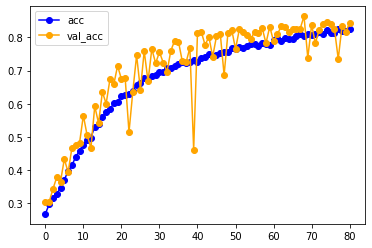

In [12]:
plot_training_progress(csv_file_path = "{fold}log_{ts}.csv".format(fold = config_log_folder, ts = config_model_timestamp),
                       train_metric = 'acc',
                       validation_metric = 'val_acc')

#### Load model & predict on test set using generator

In [13]:
cnn_model = keras.models.load_model(config_model_save_name)
probabilities = cnn_model.predict_generator(test_generator)

W0828 00:38:52.264755 12028 deprecation.py:506] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0828 00:38:52.266753 12028 deprecation.py:506] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0828 00:38:52.281751 12028 deprecation.py:506] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be remove

#### True Positives / Class by Class Accuracy

In [14]:
class_list.sort()
actual_list = []
est_prob_of_actual = []
for i, y in enumerate(agg_test_y):
    est_prob_of_actual.append(probabilities[i, class_list.index(y)])
    actual_list.append(y)

In [42]:
tpr_npr_actual = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []
for i, y in enumerate(agg_test_y):
    for z in range(len(class_list)):
        tpr_npr_actual.append(y)
        if z == class_list.index(y):
            if probabilities[i, class_list.index(y)] >= 0.5:
                true_pos.append(1)
                false_pos.append(0)
                false_neg.append(0)
                true_neg.append(0)
            else:
                false_neg.append(1)
                true_neg.append(0)
                true_pos.append(0)
                false_pos.append(0)
        else:
            if probabilities[i, class_list.index(class_list[z])] < 0.5:
                false_neg.append(0)
                true_neg.append(1)
                true_pos.append(0)
                false_pos.append(0)
            else:
                false_neg.append(0)
                true_neg.append(0)
                true_pos.append(0)
                false_pos.append(1)
            
tpr_npr_df = pd.DataFrame({'class' : tpr_npr_actual,
                           'true_pos' : true_pos,
                           'true_neg' : true_neg,
                           'false_pos' : false_pos,
                           'false_neg' : false_neg})
tpr_npr_df['total_count'] = 1

tpr_npr_df = tpr_npr_df.\
groupby(['class'], as_index = False).\
agg({'true_pos' : 'sum',
     'true_neg' : 'sum',
     'false_pos' : 'sum',
     'false_neg' : 'sum',
    'total_count' : 'sum'})

tpr_npr_df['true_positive_rate'] = tpr_npr_df['true_pos'] / (tpr_npr_df['true_pos'] + tpr_npr_df['false_neg'])
tpr_npr_df['true_negative_rate'] = tpr_npr_df['true_neg'] / (tpr_npr_df['true_neg'] + tpr_npr_df['false_pos'])
tpr_npr_df['accuracy'] = (tpr_npr_df['true_neg'] + tpr_npr_df['true_pos']) / (tpr_npr_df['true_neg'] + tpr_npr_df['true_pos'] + tpr_npr_df['false_pos'] + tpr_npr_df['false_neg'])

tpr_npr_df.head(10)

,class,true_pos,true_neg,false_pos,false_neg,total_count,true_positive_rate,true_negative_rate,accuracy
0,bathroom,234,1136,20,55,1445,0.809689,0.982699,0.948097
1,bedroom,280,1475,29,96,1880,0.744681,0.980718,0.933511
2,diningroom,182,916,16,51,1165,0.781116,0.982833,0.942489
3,kitchen,324,1602,26,83,2035,0.796069,0.984029,0.946437
4,livingroom,280,1387,17,71,1755,0.797721,0.987892,0.949858


#### Plot estimated probabalities of each class

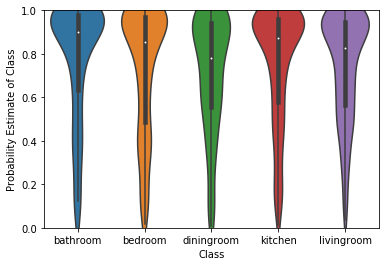

In [35]:
import seaborn as sns
class_est_df = pd.DataFrame({'Class': actual_list, 'Probability Estimate of Class' : est_prob_of_actual})
ax = sns.violinplot(x = 'Class', y = 'Probability Estimate of Class', data = class_est_df, split=True)
ax.set_ylim([0,1])
plt.show()

#### AUC by Class

In [15]:
test_set_auc = multiclass_auc(probabilities, agg_test_y, class_list)
print(pd.DataFrame(test_set_auc, index = ['AUC']))

     bathroom  bedroom  diningroom   kitchen  livingroom
AUC  0.980466  0.97702    0.979557  0.984914     0.97196


#### Load test set manually to plot individual predictions

In [16]:
test_x = [resize(np.array(load_img(c)), (config_img_height, config_img_width)) for c in agg_test_files]    

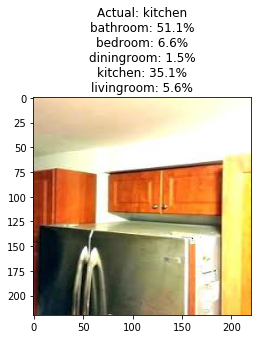

In [17]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

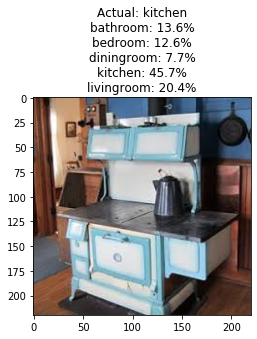

In [18]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

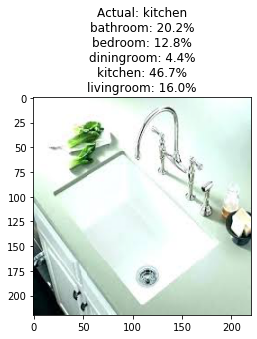

In [19]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

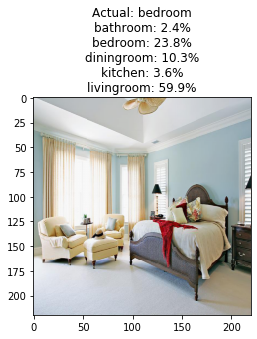

In [20]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

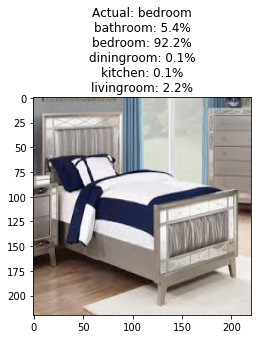

In [21]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

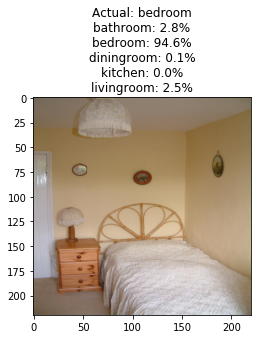

In [22]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

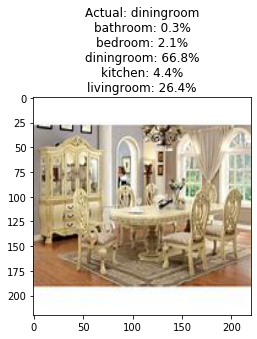

In [23]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

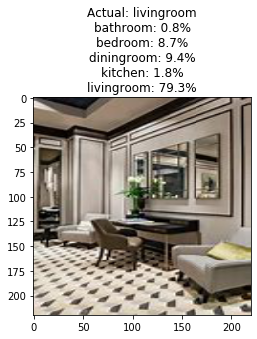

In [24]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

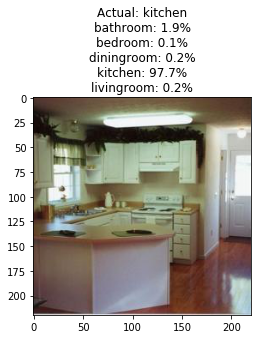

In [25]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

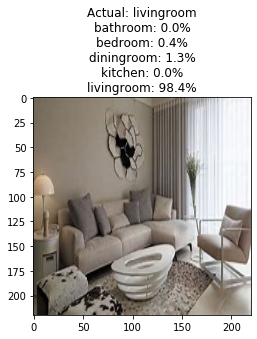

In [26]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

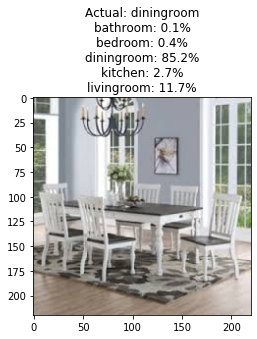

In [27]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

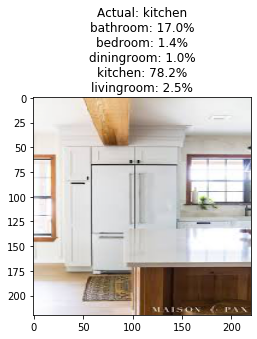

In [28]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)

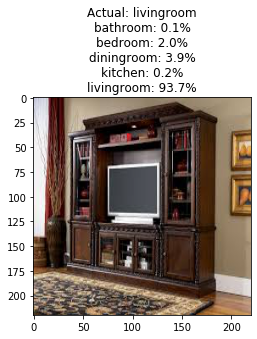

In [29]:
plot_random_test_pred(agg_test_y, probabilities, class_list, test_x)